In [2]:
import sys
import numpy as np

from astroquery.simbad import Simbad

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table, Column
import astropy.units as u

from scipy.ndimage import shift
from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks

from photutils import DAOStarFinder, CircularAperture, aperture_photometry
from ccdproc import CCDData, Combiner, subtract_overscan, trim_image
from astroquery.mast import Catalogs
from reproject import reproject_interp

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullLocator
import matplotlib.patches as patches

## Getting the list of known Cepheids in NGC 1866

Got this table from the OGLE Collection of Variable Stars (http://ogledb.astrouw.edu.pl/~ogle/OCVS/)

In [3]:
ogle_table = Table.read("../data/NGC1866_data_tables/OGLE_cepheids.txt", format='ascii')

#### Getting our list of variables

In [4]:
full_crossmatch_table = Table.read("../data/NGC1866_data_tables/variable_star_parameter_table.ecsv",
                                   format="ascii.ecsv")
mask = (full_crossmatch_table["score_best"] < -5)
passing_variable_table = full_crossmatch_table[mask]

In [5]:
len(passing_variable_table)

27

#### Loading a template image to overlay on

In [6]:
v_template_img = fits.getdata("../data/NGC1866_images/v_mean_template_crr.fits")
i_template_img = fits.getdata("../data/NGC1866_images/i_mean_template_crr.fits")

In [7]:
canonical_wcs = WCS("../data/NGC1866_images/v_mean_template_crr.fits")

#### Cross-matching the sources

In [8]:
full_crossmatch_table["skycoord"]=SkyCoord(*canonical_wcs.all_pix2world(full_crossmatch_table['x_t'], 
                                                                        full_crossmatch_table['y_t'], 0), unit='deg')

In [9]:
ogle_table["skycoord"] = SkyCoord(ogle_table['RA'],ogle_table["Decl"],unit=(u.hourangle, u.deg))

In [10]:
idx, d2d, d3d = full_crossmatch_table["skycoord"].match_to_catalog_sky(ogle_table['skycoord'])

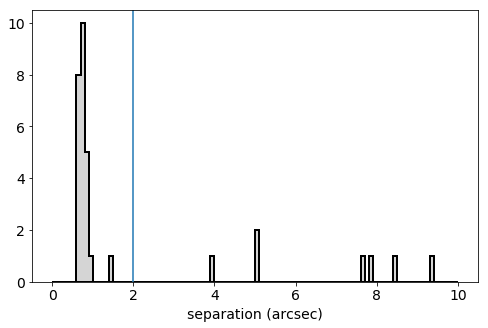

In [11]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=14)
 
ax.hist(d2d.arcsec, bins=100, range=(0,10),edgecolor='black',  linewidth=2,histtype='stepfilled', color="#d5d5d5")
ax.set_xlabel('separation (arcsec)',fontsize=14)

ax.axvline(2) # putting in a line at the fwhm

plt.show()

In [12]:
full_crossmatch_table["dist"]=d2d.arcsec*u.arcsec
full_crossmatch_table.add_column(Column(name="ogle_idx",data=idx))

In [13]:
mask_ogle = full_crossmatch_table['dist'] <= 2
sum(mask_ogle)

25

### Making a combined table with our info and OGLE info

In [14]:
ogle_crossmatch = full_crossmatch_table["id","x_t","y_t","skycoord","period_best","score_best","ogle_idx"][mask_ogle]

In [15]:
ogle_crossmatch.rename_column("x_t","x")
ogle_crossmatch.rename_column("y_t","y")
ogle_crossmatch.rename_column("period_best","period")
ogle_crossmatch.rename_column("score_best","score")

In [16]:
ogle_crossmatch["id_ogle"] = ogle_table[ogle_crossmatch["ogle_idx"]]["ID"]
ogle_crossmatch["mode_ogle"] = ogle_table[ogle_crossmatch["ogle_idx"]]["Mode"]
ogle_crossmatch["P_1"] = ogle_table[ogle_crossmatch["ogle_idx"]]["P_1"]
ogle_crossmatch["dP_1"] = ogle_table[ogle_crossmatch["ogle_idx"]]["dP_1"]

#### Getting the pixel coordinates of the OGLE sources

In [17]:
x,y = canonical_wcs.all_world2pix(Angle(ogle_table["RA"],unit='hour').deg,
                                  Angle(ogle_table["Decl"],unit='deg').deg,0)

ogle_table['x'] = x
ogle_table['y'] = y

ogle_table['x'][ogle_crossmatch["ogle_idx"]] = ogle_crossmatch['x']
ogle_table['y'][ogle_crossmatch["ogle_idx"]] = ogle_crossmatch['y']

/Users/cbrasseur/anaconda/envs/astroconda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


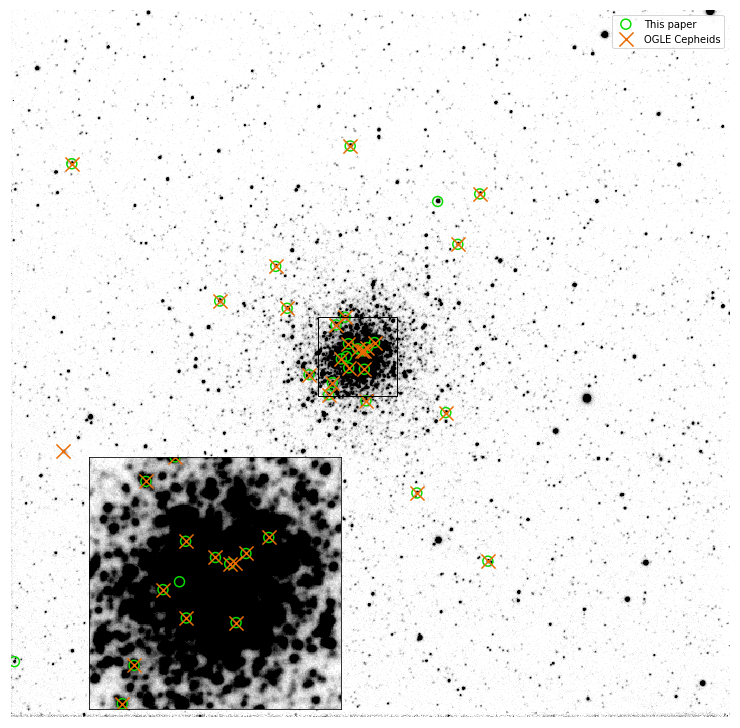

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())

ax.imshow(v_template_img, cmap='gray_r',vmin=3,vmax=15)

ax.scatter(full_crossmatch_table['x_t'][mask], full_crossmatch_table['y_t'][mask],linewidths=1.5,
           linestyle='None',marker='o',alpha=1,s=100,color="none",edgecolor='#0adc00', label="This paper")

ax.scatter(ogle_table['x'],ogle_table['y'],
           linestyle='None',marker='x',alpha=1,s=200,color='#ec6b00', linewidths=1.5, label="OGLE Cepheids")

rect = patches.Rectangle((875,875),225,225,linewidth=1,edgecolor='black',facecolor='none')
ax.add_patch(rect)

ax.set_xlim(0,v_template_img.shape[1])
ax.set_ylim(v_template_img.shape[0],0)

ax.legend()

# INSERT
left, bottom, width, height = [0.11, 0.02, 0.35, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.imshow(v_template_img, cmap='gray_r',vmin=3,vmax=15)
ax2.scatter(full_crossmatch_table['x_t'][mask], full_crossmatch_table['y_t'][mask],linewidths=1.5,
            linestyle='None',marker='o',alpha=1,s=100,color="none",edgecolor='#0adc00')

ax2.scatter(ogle_table['x'],ogle_table['y'],
            linestyle='None',marker='x',alpha=1,s=200,color='#ec6b00', linewidths=1.5)

ax2.set_xlim(875,1100)
ax2.set_ylim(1100,875)

ax2.xaxis.set_major_locator(NullLocator())
ax2.yaxis.set_major_locator(NullLocator())

fig.tight_layout(pad=0)

fig.savefig("../doc/plots/ogle_comparison.pdf")

plt.show()

### Showing the OGLE Sources on a difference image

In [20]:
v_combined_difference = fits.getdata('../data/NGC1866_images/v_combined_difference.fits')

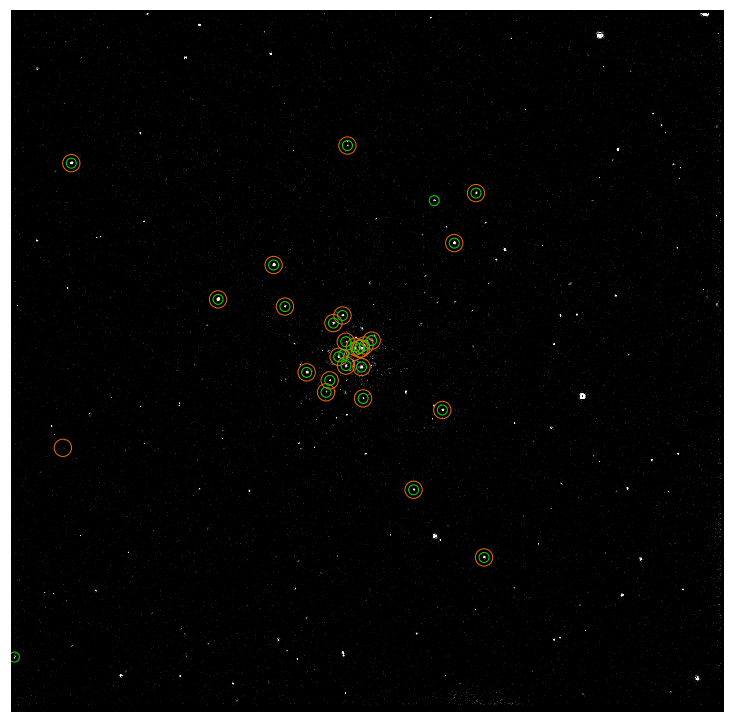

In [21]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.axis('off')
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())
fig.tight_layout(pad=0)

ax.imshow(v_combined_difference, cmap='gray',vmin=1,vmax=5)

ax.set_xlim(0,v_template_img.shape[1])
ax.set_ylim(v_template_img.shape[0],0)


ax.scatter(ogle_table['x'],ogle_table['y'],
           linestyle='None',marker='o',alpha=1,s=300,color='none',edgecolor='#ec6b00')

ax.scatter(full_crossmatch_table['x_t'][mask], full_crossmatch_table['y_t'][mask],linewidths=1,
           linestyle='None',marker='o',alpha=1,s=100,color="none",edgecolor='#0adc00', label="This paper")

fig.savefig("../doc/plots/ogle_comparison_difimg.pdf")

plt.show()


## Comparing periods

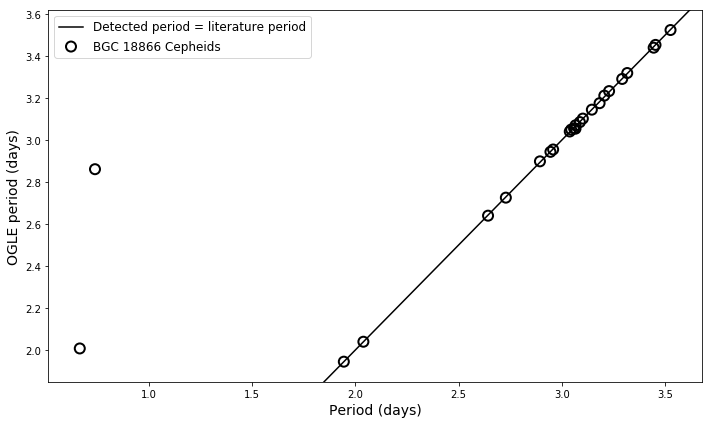

In [22]:
fig = plt.figure(figsize=(10,6))
    
ax1 = fig.add_subplot(111)
    
ax1.scatter(ogle_crossmatch["period"], ogle_crossmatch["P_1"], label="BGC 18866 Cepheids",
            marker='o',linestyle='None', edgecolor='black', color='none', s=100, linewidths=2)

ax1.set_xlim(*ax1.get_xlim())
ax1.set_ylim(*ax1.get_ylim())
x = np.linspace(1.5,4,10)
ax1.plot(x,x, color='black', label="Detected period = literature period")

ax1.set_xlabel("Period (days)", fontsize=14)
ax1.set_ylabel("OGLE period (days)", fontsize=14)

ax1.legend(fontsize=12)

plt.tight_layout()

plt.savefig("../doc/plots/period_comparison.pdf")
        
plt.show()  

## Looking at the two that are bad

Need the period scoring function again

In [23]:
def score_period(times, mags, period, hist_size=8, uselog=False, verbose=False):
    """
    Given a period score how good a fit it is.
    Uses the same algorithm as the VARTOOLS Light Curve Analysis Program.  
    """
    
    # initialize the histograms 
    histN = np.zeros(hist_size)
    histA = np.zeros(hist_size)
    histB = np.zeros(hist_size)
    histC = np.zeros(hist_size)
    histD = np.zeros(hist_size)
    histE = np.zeros(hist_size)
    
    for i in range(len(times)):
        if np.isnan(mags[i]):
            continue
            
        X = np.fmod(times[i], period) / period
        index = int(hist_size * X)
        Y = mags[i]
        
        histN[index] += 1
        histA[index] += X
        histB[index] += X * X
        histC[index] += X * Y
        histD[index] += Y
        histE[index] += Y * Y

    sums = 0
    s1 = 0
    L2 = 0
    
    for i in range(hist_size):
        N = histN[i];
        
        if (N <= 1):
            if verbose:
                print("None enough mags in bin.")
            return(100000.0) # Error score, assumed to be bigger than a valid score
        
        Y = histD[i];
        X = Y * Y / N;
        
        # Checking on the denominator
        if ((N*(np.square(histA[i]) - (histB[i]*N)))) == 0:
            #(X + X)^2 - 2*(X^2 + X^2) 
            #print(np.square(histA[i]))
            #print(histB[i]*N)
            #print(histC[i])
            #print(histD[i])
            #print(histE[i])
            #print(histN[i])
            #print()
            continue
        sums += Y
        s1 += X 
        L2 += (np.square((histC[i]*N) - (Y*histA[i])) / (N*(np.square(histA[i]) - (histB[i]*N)))) + histE[i] - X
    
    s1 -= sums * sums / len(times)
    L2 /= len(times) - hist_size
    
    if ((s1 <= 0) or (L2 <= 0)):
        if verbose:
            print("Negative s1 or L2")
        return(100000.0) # Error score, assumed to be bigger than a valid score
    elif(uselog):
        return(np.log(L2 / s1))
    else:
        return(-s1/L2)

In [24]:
bad_pds = ogle_crossmatch[ogle_crossmatch["period"]<1]
bad_pds

id,x,y,skycoord,period,score,ogle_idx,id_ogle,mode_ogle,P_1,dP_1
,,,"deg,deg",,,,,,,
int64,float64,float64,object,float64,float64,int64,str17,str1,float64,float64
34,961.607523162175,1018.6149326415621,"78.41674444040883,-65.46175387935166",0.7400552486187845,-5.221984632436257,23,OGLE-LMC-CEP-3742,F,2.8603779,4.7e-06
38,904.4585878101693,1095.1153876906985,"78.42816624502882,-65.45531877990209",0.6664179104477612,-6.442274337137753,28,OGLE-LMC-CEP-3747,1,2.0071704,6e-06


In [25]:
bad_pds["P_1"]/bad_pds["period"]

3.86508697200448
3.0118794356103025


The second one looks like maybe it's a multiple, not so sure about the top one. Lets look at their periodograms.

In [26]:
lc_table_v = Table.read("../data/NGC1866_data_tables/Vband_variable_lightcurve_table.ecsv",format='ascii.ecsv')
lc_table_i = Table.read("../data/NGC1866_data_tables/Iband_variable_lightcurve_table.ecsv",format='ascii.ecsv')

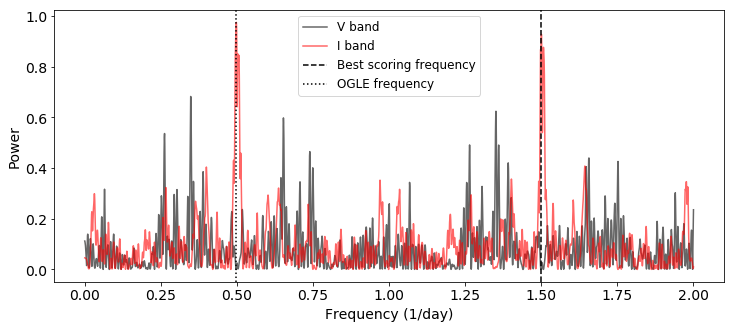

In [292]:
#idx = 34
#b_ind = 0

idx = 38
b_ind = 1

# Getting the v_band periodogram
vtimes = lc_table_v['date_obs']
vmags = lc_table_v[f'mag_{idx}'] 
verrs = lc_table_v[f'mag_err_{idx}']
    
# Getting rid of the nans
vtimes = vtimes[~np.isnan(vmags)]
verrs = verrs[~np.isnan(vmags)]
vmags = vmags[~np.isnan(vmags)]
    
# Doing the periodogram
frequency = np.linspace(0,2,2680)
frequency = frequency[1:] # need to get rid of the literal 0 point

vlomb = LombScargle(vtimes,vmags)
vpower = lomb.power(frequency)
    
# Getting the i_band periodogram    
itimes = lc_table_i['date_obs']
imags = lc_table_i[f'mag_{idx}'] 
ierrs = lc_table_i[f'mag_err_{idx}']
    
# Getting rid of the nans
itimes = itimes[~np.isnan(imags)]
ierrs = ierrs[~np.isnan(imags)]
imags = imags[~np.isnan(imags)]
    
# Doing the periodogram
frequency = np.linspace(0,2,2680)
frequency = frequency[1:] # need to get rid of the literal 0 point

ilomb = LombScargle(itimes,imags)
ipower = ilomb.power(frequency)  

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax1.plot(frequency, vpower, color='black', alpha=0.6, label="V band")
ax1.plot(frequency, ipower, color='red', alpha=0.6, label="I band")

# Drawing the periods
plt.axvline(x=1/bad_pds[b_ind]["period"], linestyle="--", color='black', label="Best scoring frequency")  
plt.axvline(x=1/bad_pds[b_ind]["P_1"], linestyle=":", color='black', label="OGLE frequency")

ax1.set_xlabel("Frequency (1/day)", size=14)
ax1.set_ylabel("Power", size=14)

ax1.legend(fontsize=12)

plt.savefig(f"../doc/plots/periodogram_badpd_idx{idx}.pdf")
        
plt.show()  

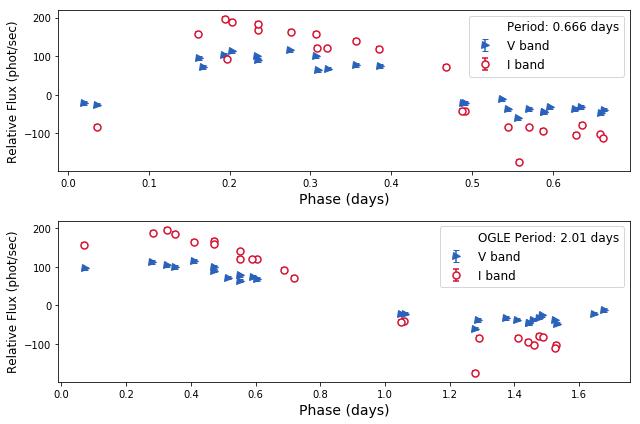

In [293]:
period = bad_pds["period"][b_ind]
ogle_pd = bad_pds["P_1"][b_ind]
    
fig = plt.figure(figsize=(9,6))
    
ax1 = fig.add_subplot(211)
ax1.errorbar([period/4],[0],color='white',label=f"Period: {period:.3} days")
ax1.errorbar(lc_table_v['date_obs']%period, lc_table_v[f"mag_{idx}"], yerr=lc_table_v[f"mag_err_{idx}"],
    marker='>',linestyle='None',capsize=3,color='#2a61bb', ms=7, label=f"V band")
ax1.errorbar(lc_table_i['date_obs']%period, lc_table_i[f"mag_{idx}"], yerr=lc_table_i[f"mag_err_{idx}"],
    marker='o',linestyle='None',capsize=3, mec='#d71031', color='#d71031', mfc='white', mew=1.5,
    ms=7, label=f"I band")
    
ax1.set_xlabel("Phase (days)", fontsize=14)
ax1.set_ylabel("Relative Flux (phot/sec)", fontsize=12)
ax1.legend(fontsize=12)#, loc="upper left") 

ax2 = fig.add_subplot(212)
ax2.errorbar([ogle_pd/4],[0],color='white',label=f"OGLE Period: {ogle_pd:.3} days")
ax2.errorbar(lc_table_v['date_obs']%ogle_pd, lc_table_v[f"mag_{idx}"], yerr=lc_table_v[f"mag_err_{idx}"],
    marker='>',linestyle='None',capsize=3,color='#2a61bb', ms=7, label=f"V band")
ax2.errorbar(lc_table_i['date_obs']%ogle_pd, lc_table_i[f"mag_{idx}"], yerr=lc_table_i[f"mag_err_{idx}"],
    marker='o',linestyle='None',capsize=3, mec='#d71031', color='#d71031', mfc='white', mew=1.5,
    ms=7, label=f"I band")
    
ax2.set_xlabel("Phase (days)", fontsize=14)
ax2.set_ylabel("Relative Flux (phot/sec)", fontsize=12)
ax2.legend(fontsize=12)#, loc="upper left") 



    
plt.tight_layout()
        
plt.savefig(f"../doc/plots/phased_lc__badpd_idx{idx}.pdf")

        
plt.show()  